# About this notebook
- PyTorch resnet18d starter code
- StratifiedKFold 5 folds

If this notebook is helpful, feel free to upvote :)

# Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('seti-breakthrough-listen/train_labels.csv')
#train_old = pd.read_csv('seti-breakthrough-listen/old_leaky_data/train_labels_old.csv')

test = pd.read_csv('seti-breakthrough-listen/sample_submission.csv')

def get_train_file_path(image_id):
    return "seti-breakthrough-listen/train/{}/{}.npy".format(image_id[0], image_id)
"""
def get_train__old_file_path(image_id):
    return "seti-breakthrough-listen/old_leaky_data/train_old/{}/{}.npy".format(image_id[0], image_id)
"""

def get_test_file_path(image_id):
    return "seti-breakthrough-listen/test/{}/{}.npy".format(image_id[0], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,id,target,file_path
0,0000799a2b2c42d,0,seti-breakthrough-listen/train/0/0000799a2b2c4...
1,00042890562ff68,0,seti-breakthrough-listen/train/0/00042890562ff...
2,0005364cdcb8e5b,0,seti-breakthrough-listen/train/0/0005364cdcb8e...
3,0007a5a46901c56,0,seti-breakthrough-listen/train/0/0007a5a46901c...
4,0009283e145448e,0,seti-breakthrough-listen/train/0/0009283e14544...


,id,target,file_path
0,000bf832cae9ff1,0.5,seti-breakthrough-listen/test/0/000bf832cae9ff...
1,000c74cc71a1140,0.5,seti-breakthrough-listen/test/0/000c74cc71a114...
2,000f5f9851161d3,0.5,seti-breakthrough-listen/test/0/000f5f9851161d...
3,000f7499e95aba6,0.5,seti-breakthrough-listen/test/0/000f7499e95aba...
4,00133ce6ec257f9,0.5,seti-breakthrough-listen/test/0/00133ce6ec257f...


# Quick EDA

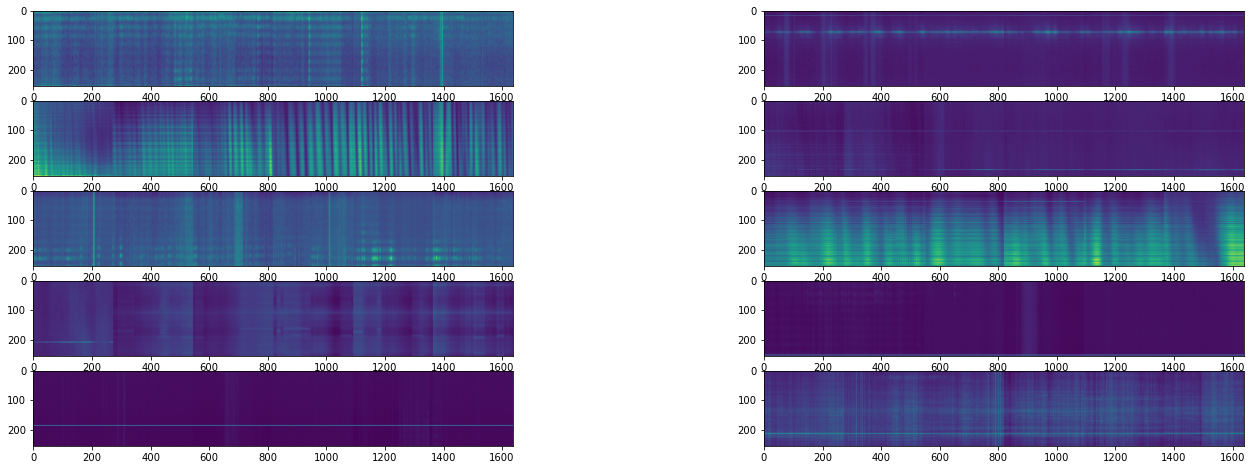

In [3]:
plt.figure(figsize=(24, 8))
for i in range(10):
    image = np.load(train.loc[i, 'file_path']) # (6, 273, 256)
    image = image.astype(np.float32)
    image = np.vstack(image).transpose((1, 0)) # (1638, 256) -> (256, 1638)
    plt.subplot(5, 2, i + 1)
    plt.imshow(image)
plt.show()

<AxesSubplot:>

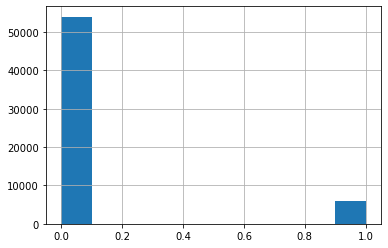

In [4]:
train['target'].hist()

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=100
    num_workers=4
    model_name='eca_nfnet_l0'
    size=512
    scheduler='ReduceLROnPlateau' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    criterion = 'BCE'
    epochs=15 #15or20
    factor=0.2 # ReduceLROnPlateau
    patience=2 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    #T_max=15# CosineAnnealingLR
    #T_0=20 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='target'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    mix_up=True # True or False
    cut_mix=False # True or False
    sam =True
    warmup_epochs=0
    multiplier=10
    multisample_dropout=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from torch.optim.optimizer import Optimizer

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, LambdaLR

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform

import timm
from adamp import AdamP
from torch.cuda.amp import autocast, GradScaler
from warmup_scheduler import GradualWarmupScheduler
import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import mlflow
remote_server_uri = "" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [9]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'target']).size())

fold  target
0     0         10800
      1          1200
1     0         10800
      1          1200
2     0         10800
      1          1200
3     0         10800
      1          1200
4     0         10800
      1          1200
dtype: int64

# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = np.load(file_path)
        image = image[::2]
        image = image.astype(np.float32)
        image = np.vstack(image).transpose((1, 0))

        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        label = torch.tensor(self.labels[idx]).float()
        return image, label

# Transforms

In [11]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(rotate_limit=0, p=0.25),
            A.OneOf([
                A.MotionBlur(p=1.0),
                A.GaussianBlur(p=1.0),
                A.GaussNoise(p=1.0),
            ], p=0.2),
            A.OneOf([
                A.OpticalDistortion(distort_limit=1.0, p=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.0, p=1.0),
                A.ElasticTransform(alpha=3, p=1.0),
            ], p=0.2),
            A.IAASharpen(p=0.25),
            A.Cutout(p=0.3),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            ToTensorV2(),
        ])

In [12]:
def mixup_data(x, y, alpha=0.5, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [13]:
def rand_bbox(W, H, lam):
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(cut_w // 2, W - cut_w // 2)
    cy = np.random.randint(cut_h // 2, H - cut_h // 2)

    bbx1 = cx - cut_w // 2
    bby1 = cy - cut_h // 2
    bbx2 = cx + cut_w // 2
    bby2 = cy + cut_h // 2

    return bbx1, bby1, bbx2, bby2

def cutmix(x, y, alpha=0.5):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size()[1], x.size()[2], lam)
    x[:, bbx1:bbx2, bby1:bby2] = x[index, bbx1:bbx2, bby1:bby2]
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# MODEL

In [14]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [15]:
class GAP(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return F.adaptive_avg_pool2d(x, (1,1)).squeeze()

In [16]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        if  "eff" in self.cfg.model_name:
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)
        elif "mixer" in self.cfg.model_name:
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, self.cfg.target_size)
        elif "resnest" in self.cfg.model_name:
            self.n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(self.n_features, self.cfg.target_size)
        elif "nfnet" in self.cfg.model_name:
            self.n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(self.n_features, self.cfg.target_size)
        else:
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, self.cfg.target_size)
        self.dropout = nn.Dropout(0.2)
        self.global_pool = GAP()
        self.flatten = nn.Flatten()
        self.l0 = nn.Linear(self.n_features, self.cfg.target_size)
        
    def forward(self, x):
        if self.cfg.multisample_dropout:
            features = self.model.forward_features(x)
            x = self.global_pool(features)
            x = self.flatten(x)
            x = torch.mean(
                torch.stack(
                    [self.l0(self.dropout(x)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        else:
            x = self.model(x)
        return x

# Helper functions

In [17]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [18]:
class Mish_func(torch.autograd.Function):
    
    """from: https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py"""
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)


def replace_activations(model, existing_layer, new_layer):
    
    """A function for replacing existing activation layers"""
    
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [19]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        batch_size = labels.size(0)
        
        if CFG.mix_up:
            inputs1, targets_a, targets_b, lam = mixup_data(images, labels.view(-1, 1), use_cuda=True)

            inputs1 = inputs1.to(device, dtype=torch.float)
            targets_a = targets_a.to(device, dtype=torch.float)
            targets_b = targets_b.to(device, dtype=torch.float)
            
            if CFG.apex:
                with autocast():
                    outputs = model(inputs1)
                    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs1)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        elif CFG.cut_mix:
            inputs1, targets_a, targets_b, lam = cutmix(images, labels.view(-1, 1))

            inputs1 = inputs1.to(device, dtype=torch.float)
            targets_a = targets_a.to(device, dtype=torch.float)
            targets_b = targets_b.to(device, dtype=torch.float)
            
            if CFG.apex:
                with autocast():
                    outputs = model(inputs1)
                    loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs1)
                loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            if CFG.apex:
                with autocast():
                    y_preds = model(images)
                    loss = criterion(y_preds.view(-1), labels)
            else:
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
                
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)　
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            else:
                if CFG.sam:
                    optimizer.first_step(zero_grad=True)
                    
                    if CFG.mix_up:
                        mixup_criterion(criterion, model(inputs1), targets_a, targets_b, lam).backward()
                    elif CFG.cut_mix:
                        cutmix_criterion(criterion, model(inputs1), targets_a, targets_b, lam).backward()
                    else:
                        criterion(model(images).view(-1), labels).backward()
                    
                    optimizer.second_step(zero_grad=True)
                else:
                    optimizer.step()
                    optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            #mlflow.log_metric('lr', scheduler.get_lr()[0], step=epoch)
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [20]:
#credit : https://github.com/Yonghongwei/Gradient-Centralization

def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
    return x


class Ranger(Optimizer):

    def __init__(self, params, lr=1e-4,                       # lr
                 alpha=0.5, k=5, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-6, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False, gc_loc=True
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                # if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                # if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                # GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(G_grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [21]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)
        
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [22]:
class FocalLoss(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """

    def __init__(self, alpha=0.3, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 1e-12  # prevent training from Nan-loss error

    def forward(self, logits, target):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = F.sigmoid(logits)
        one_subtract_probs = 1.0 - probs
        # add epsilon
        probs_new = probs + self.epsilon
        one_subtract_probs_new = one_subtract_probs + self.epsilon
        # calculate focal loss
        log_pt = target * torch.log(probs_new) + (1.0 - target) * torch.log(one_subtract_probs_new)
        pt = torch.exp(log_pt)
        focal_loss = -1.0 * (self.alpha * (1 - pt) ** self.gamma) * log_pt
        return torch.mean(focal_loss)

In [23]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.smoothing = smoothing 

    def forward(self,logits, labels):
        labels[labels == 1] = 1 - self.smoothing 
        labels[labels == 0] = self.smoothing 
        return F.binary_cross_entropy_with_logits(logits, labels)

# Train loop

In [24]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ==================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        if CFG.warmup_epochs > 0:
            scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=CFG.multiplier,total_epoch=CFG.warmup_epochs, after_scheduler=scheduler)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    #model = replace_activations(model, torch.nn.SiLU, Mish())
    model.to(device)
    if CFG.sam:
        base_optimizer = AdamP
        optimizer = SAM(model.parameters(), base_optimizer, lr=CFG.lr, weight_decay=CFG.weight_decay)
    else:
        optimizer = Ranger(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
            
        scheduler.step(avg_val_loss)

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        
        mlflow.log_metric('avg_train_loss', avg_loss, step=epoch)
        mlflow.log_metric('avg_val_loss', avg_val_loss, step=epoch)
        mlflow.log_metric('roc_auc', score, step=epoch)
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [25]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            with mlflow.start_run():
                #paramの保存
                for key, value in CFG.__dict__.items():
                    mlflow.log_param(key, value)
                
                #実行モデル名、説明を書く
                mlflow.set_tag('mlflow.source.name', 'pytorch-ecanfnet-l0-15ep')
                mlflow.set_tag('mlflow.models.name', CFG.model_name)
                mlflow.set_tag('mlflow.user.name', 'mizo')
                #mlflow.set_tag('mlflow.note.content', 'baseline-model')
                mlflow.set_tag('fold', fold)
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(train, fold)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
            # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        mlflow.end_run()

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


Epoch: [1][0/1500] Data 3.159 (3.159) Elapsed 0m 6s (remain 172m 5s) Loss: 0.7087(0.7087) Grad: 3.2880  
